The objective of this analysis is to get some insights by comparing the spread of the virus with the trend of mobility

# Libraries import

In [1]:
import pandas as pd
import datetime
import numpy as np
import matplotlib
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import re
import matplotlib.pyplot as plt
matplotlib.style.use(["ggplot"])

# Importation of the datasets

## Covid-19

The Covid19 dataset is provided by John Hopkins University. The dataset is updated every day

In [2]:
# url towards the Github repository
url_racine = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/"

In [3]:
# the date from which CSSE repository started to collect data
date_begin = datetime.date(2020,1,22)

# download of the data
date_end = datetime.date.today()

range_of_date = pd.date_range(date_begin,end=date_end).strftime("%m-%d-%Y").tolist()

In [4]:
range_of_date_iter = range_of_date
iterative = 0
records = pd.DataFrame()
except_dates = []
result = {}
while (len(except_dates)>1 and iterative < 5) or (iterative == 0):
    iterative += 1
    print(except_dates)
    except_dates = []
    for date_given in range_of_date_iter:
        try:
            temp = pd.read_csv(url_racine + date_given + ".csv")
            num = temp.shape[0]
            temp["date"] = np.repeat(date_given,num)
            temp["Date"] = [datetime.datetime.strptime(date_str,'%m-%d-%Y') for date_str in temp.date]
            #temp = temp.drop(columns=["date"])
            records = records.append(temp,sort=False)
        except:
            except_dates.append(date_given)
            pass
    range_of_date_iter = except_dates
    result["table"+str(iterative)]=records
    records = pd.DataFrame()
    
records = result["table1"]

[]


In [5]:
records[records.Country_Region=="US"].head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,date,Date,Latitude,Longitude,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Active,Combined_Key
0,NaN,NaN,NaN,9654.0,63.0,0.0,03-22-2020,2020-03-22,NaN,NaN,36061.0,New York City,New York,US,3/22/20 23:45,40.767273,-73.971526,0.0,"New York City, New York, US"
1,NaN,NaN,NaN,1900.0,4.0,0.0,03-22-2020,2020-03-22,NaN,NaN,36059.0,Nassau,New York,US,3/22/20 23:45,40.740665,-73.589419,0.0,"Nassau, New York, US"
2,NaN,NaN,NaN,1873.0,0.0,0.0,03-22-2020,2020-03-22,NaN,NaN,36119.0,Westchester,New York,US,3/22/20 23:45,41.162784,-73.757417,0.0,"Westchester, New York, US"
3,NaN,NaN,NaN,1034.0,9.0,0.0,03-22-2020,2020-03-22,NaN,NaN,36103.0,Suffolk,New York,US,3/22/20 23:45,40.883201,-72.801217,0.0,"Suffolk, New York, US"
4,NaN,NaN,NaN,455.0,1.0,0.0,03-22-2020,2020-03-22,NaN,NaN,36087.0,Rockland,New York,US,3/22/20 23:45,41.150279,-74.025605,0.0,"Rockland, New York, US"


In [6]:
records.dtypes

Province/State            object
Country/Region            object
Last Update               object
Confirmed                float64
Deaths                   float64
Recovered                float64
date                      object
Date              datetime64[ns]
Latitude                 float64
Longitude                float64
FIPS                     float64
Admin2                    object
Province_State            object
Country_Region            object
Last_Update               object
Lat                      float64
Long_                    float64
Active                   float64
Combined_Key              object
dtype: object

we can notice that there are variables with the same information. They are:
* **Province/State** and **Province\_State**
* **Country/Region** and **Country\_Region**
* **Lat** and **Latitude**
* **Long_** and **Longitude**

Let's combine them into one variable each

In [7]:
records["Prov"] = records["Province/State"].combine_first(records["Province_State"])
records["Country"] = records["Country/Region"].combine_first(records["Country_Region"])
records["Lati"] = records["Latitude"].combine_first(records["Lat"])
records["Longi"] = records["Longitude"].combine_first(records["Long_"])

Then drop the redundant variables and the unused ones.

In [8]:
records.drop(columns=["Province/State",
"date",
"Province_State",
"Country_Region",
"Country/Region",
"Last Update",
"Last_Update",
"Longitude",
"Long_",
"Latitude",
"Lat",
"FIPS",],inplace=True)

In [9]:
print("the shape of the data is: \n{}".format(records.shape))
records.sort_values(["Confirmed"],ascending=False).head()

the shape of the data is: 
(171876, 11)


,Confirmed,Deaths,Recovered,Date,Admin2,Active,Combined_Key,Prov,Country,Lati,Longi
3192,242271.0,2212.0,48003.0,2020-05-13,NaN,192056.0,Russia,NaN,Russia,61.524010,105.318756
3140,236899.0,24275.0,132929.0,2020-04-29,NaN,79695.0,Spain,NaN,Spain,40.463667,-3.749220
3190,232243.0,2116.0,43512.0,2020-05-12,NaN,186615.0,Russia,NaN,Russia,61.524010,105.318756
3135,232128.0,23822.0,123903.0,2020-04-28,NaN,84403.0,Spain,NaN,Spain,40.463667,-3.749220
3229,229705.0,33186.0,0.0,2020-05-13,NaN,196519.0,United Kingdom,NaN,United Kingdom,55.378100,-3.436000


In [10]:
records.dtypes

Confirmed              float64
Deaths                 float64
Recovered              float64
Date            datetime64[ns]
Admin2                  object
Active                 float64
Combined_Key            object
Prov                    object
Country                 object
Lati                   float64
Longi                  float64
dtype: object

### Numerical variables

In [11]:
records.describe()

,Confirmed,Deaths,Recovered,Active,Lati,Longi
count,171857.000000,171435.000000,171488.000000,164259.000000,166432.000000,166432.000000
mean,721.429066,47.216549,211.515161,439.791141,36.472861,-78.824938
std,7452.100521,768.224419,3776.581259,5064.749651,10.583063,44.532687
min,0.000000,0.000000,0.000000,-238428.000000,-51.796300,-170.132000
25%,2.000000,0.000000,0.000000,0.000000,33.719022,-96.152757
50%,13.000000,0.000000,0.000000,4.000000,37.855086,-87.614684
75%,75.000000,2.000000,0.000000,42.000000,41.597612,-80.662394
max,242271.000000,33186.000000,243430.000000,196519.000000,72.000000,178.065000


We exclude the observations with $Nan$ in the Confirmed variable

In [12]:
records = records[[not x for x in np.isnan(records.Confirmed)]]

there are some issues in **Confirmed** and **Deaths** variables. Some countries do not have confirmed cases with deaths... For now, we will keep those cases in the dataset.

In [13]:
records[(records.Confirmed==0)&(records.Deaths!=0)].head(5)

,Confirmed,Deaths,Recovered,Date,Admin2,Active,Combined_Key,Prov,Country,Lati,Longi
3188,0.0,1.0,0.0,2020-03-22,NaN,0.0,"Diamond Princess, Canada",Diamond Princess,Canada,0.0,0.0
2858,0.0,1.0,0.0,2020-03-23,Unassigned,0.0,"Unassigned, Florida, US",Florida,US,0.0,0.0
2875,0.0,3.0,0.0,2020-03-23,Unassigned,0.0,"Unassigned, Vermont, US",Vermont,US,0.0,0.0
3182,0.0,1.0,0.0,2020-03-23,NaN,0.0,"Diamond Princess, Canada",Diamond Princess,Canada,0.0,0.0
2856,0.0,2.0,0.0,2020-03-24,Unassigned,0.0,"Unassigned, Arizona, US",Arizona,US,0.0,0.0


### Categorical variables

In [14]:
records.describe(include="object")

,Admin2,Combined_Key,Prov,Country
count,150129,164259,159118,171857
unique,1872,3580,298,238
top,Unassigned,"Monroe, Alabama, US",Texas,US
freq,2223,53,10804,152067


Some countries are recorded with different label. As it is shown below, it is the case of:
* South Korea
* Hong Kong SAR
* China

In [15]:
def detect_rep(pattern,list_countries):
    list_countries = [x for x in list_countries if not pd.isnull(x)]
    resu = [re.findall(pattern,x,flags = re.IGNORECASE) for x in list_countries]
    vect = []
    for test1,init in zip(resu,list_countries):
        if test1!=[]:
            vect.append(init)
    return set(vect)

dict_rep_name = {"korea":detect_rep("korea",records["Country"]),"hong kong":detect_rep("hong",records["Country"]),"china":detect_rep("china",records["Country"])}
dict_rep_name

{'korea': {'Korea, South', 'Republic of Korea', 'South Korea'},
 'hong kong': {'Hong Kong', 'Hong Kong SAR'},
 'china': {'China', 'Mainland China'}}

In [16]:
# some countries are recorded with different label
records = records.assign(Country_1 = lambda df : df["Country"].map(lambda country :
  "China" if bool(re.search("china",country,flags=re.IGNORECASE)) 
else ("Hong Kong" if bool(re.search("hong",country,flags=re.IGNORECASE)) 
else ("South Korea" if bool(re.search("korea",country,flags=re.IGNORECASE)) 
else country))))

In [17]:
print("the information on the COVID19 spread span from {} to {}".format(records.Date.min(),records.Date.max()))

the information on the COVID19 spread span from 2020-01-22 00:00:00 to 2020-05-13 00:00:00


Text(0, 0.5, 'Number of Confirmed cases')

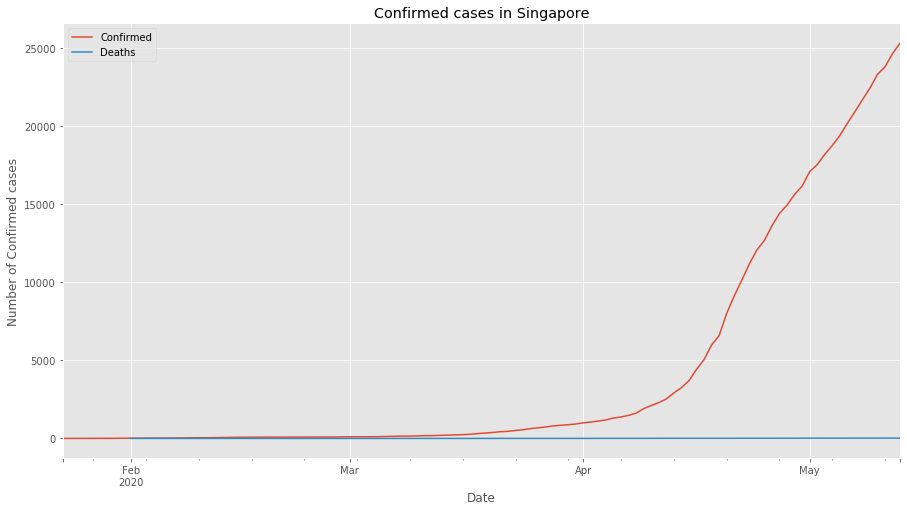

In [18]:
ax = records[records.Country_1=="Singapore"].plot(kind="line",x="Date",y=["Confirmed","Deaths"],figsize=(15,8))
ax.set_title("Confirmed cases in Singapore")
ax.set_xlabel("Date")
ax.set_ylabel("Number of Confirmed cases")

In [19]:
records[(records.Country=="France")&(records.Date=="2020-04-13")].groupby("Combined_Key").agg({"Confirmed":"sum"})

,Confirmed
Combined_Key,
France,136779.0
"French Guiana, France",86.0
"French Polynesia, France",55.0
"Guadeloupe, France",143.0
"Martinique, France",157.0
"Mayotte, France",207.0
"New Caledonia, France",18.0
"Reunion, France",391.0
"Saint Barthelemy, France",6.0


In [20]:
records[(records.Country=="France")&(records.Date=="2020-04-14")].groupby("Combined_Key").agg({"Confirmed":"sum"})

,Confirmed
Combined_Key,
France,130253.0
"French Guiana, France",86.0
"French Polynesia, France",55.0
"Guadeloupe, France",145.0
"Martinique, France",157.0
"Mayotte, France",217.0
"New Caledonia, France",18.0
"Reunion, France",391.0
"Saint Barthelemy, France",6.0


In [21]:
records[(records.Country=="France")&(records.Date=="2020-04-15")].groupby("Combined_Key").agg({"Confirmed":"sum"})

,Confirmed
Combined_Key,
France,133470.0
"French Guiana, France",86.0
"French Polynesia, France",55.0
"Guadeloupe, France",145.0
"Martinique, France",158.0
"Mayotte, France",217.0
"New Caledonia, France",18.0
"Reunion, France",391.0
"Saint Barthelemy, France",6.0


In [22]:
records.head()

,Confirmed,Deaths,Recovered,Date,Admin2,Active,Combined_Key,Prov,Country,Lati,Longi,Country_1
0,1.0,NaN,NaN,2020-01-22,NaN,NaN,NaN,Anhui,Mainland China,NaN,NaN,China
1,14.0,NaN,NaN,2020-01-22,NaN,NaN,NaN,Beijing,Mainland China,NaN,NaN,China
2,6.0,NaN,NaN,2020-01-22,NaN,NaN,NaN,Chongqing,Mainland China,NaN,NaN,China
3,1.0,NaN,NaN,2020-01-22,NaN,NaN,NaN,Fujian,Mainland China,NaN,NaN,China
5,26.0,NaN,NaN,2020-01-22,NaN,NaN,NaN,Guangdong,Mainland China,NaN,NaN,China


## Mobility trends

Here, we download the data from the mobility trend report made available by Apple. The link may not work, if so I would recommend you to directly download the data from their [page](https://www.apple.com/covid19/mobility?fbclid=IwAR0zUKTSP2CkhMRghPhOjLwNzb9Om8j524S_-ZQb1cWZP-zXxeoUXMGQ6aQ)

In [23]:
url_racine_mob = "https://covid19-static.cdn-apple.com/covid19-mobility-data/2007HotfixDev58/v2/en-us/applemobilitytrends-"
date_today = datetime.date.today()
iterative = 0
data_downloaded=0
while (iterative<10)&(data_downloaded==0):
    data_downloaded=1
    date=date_today- datetime.timedelta(days=iterative)
    date_str = date.strftime("%Y-%m-%d")
    try:
        data_mobility = pd.read_csv(url_racine_mob+date_str+".csv")
    except:
        data_downloaded=0
        pass
    iterative+=1

print("the mobility trend dataset is from the date: {}".format(date.strftime("%Y-%m-%d")))

the mobility trend dataset is from the date: 2020-05-12


In [24]:
date_str

'2020-05-12'

We need to collect the coordinates of the countries in the Apple's data. they will be retrieved from **geopy**

In [25]:
"""
from geopy.geocoders import Nominatim
locator = Nominatim(user_agent="myGeocoder")
from geopy.extra.rate_limiter import RateLimiter
geocode = RateLimiter(locator.geocode,min_delay_seconds=1)
locations = data_mobility.region.apply(geocode)

df_data_1=pd.DataFrame(columns=["adress","coord"])
tuple_loc = locations.apply(lambda loc: tuple(loc) if loc!=None else ('',()))
df_data_1[["adress","coord"]]=pd.DataFrame(tuple_loc.tolist())
df_data_1[['latitudes','longitudes']]=pd.DataFrame(df_data_1.coord.tolist())
df_data_1.drop_duplicates(inplace=True)

df_data_1.head()
df_data_1[df_data_1.adress=="France"]

df_data_1 = df_data_1[df_data_1.adress!=""]
"""

'\nfrom geopy.geocoders import Nominatim\nlocator = Nominatim(user_agent="myGeocoder")\nfrom geopy.extra.rate_limiter import RateLimiter\ngeocode = RateLimiter(locator.geocode,min_delay_seconds=1)\nlocations = data_mobility.region.apply(geocode)\n\ndf_data_1=pd.DataFrame(columns=["adress","coord"])\ntuple_loc = locations.apply(lambda loc: tuple(loc) if loc!=None else (\'\',()))\ndf_data_1[["adress","coord"]]=pd.DataFrame(tuple_loc.tolist())\ndf_data_1[[\'latitudes\',\'longitudes\']]=pd.DataFrame(df_data_1.coord.tolist())\ndf_data_1.drop_duplicates(inplace=True)\n\ndf_data_1.head()\ndf_data_1[df_data_1.adress=="France"]\n\ndf_data_1 = df_data_1[df_data_1.adress!=""]\n'

In [26]:
#df_data_1.to_csv('adress_coordinates.csv')
df_data_1=pd.read_csv('adress_coordinates.csv')

In [27]:
#!pip install folium
import folium
latitude=46.603354
longitude=1.888334
# create map of toronto using latitude and longitude values
map_world = folium.Map(location=[latitude, longitude], zoom_start=2.5)

# add markers to map
for values in df_data_1.index.values:
    adress, coord, lat,lng = df_data_1.loc[values]
    label = '{}'.format(adress)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='yellow',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_world)  

ValueError: too many values to unpack (expected 4)

Below you can see that the data gives a good view of the mobility around the world

In [ ]:
map_world

![](data_available.png)

In [ ]:
data_mobility.head()
data_mobility.drop(columns=["alternative_name"],inplace=True)

In [ ]:
data_mobility_transpose = data_mobility.set_index(["geo_type","region","transportation_type"]).T
data_mobility_transpose.head()

# Feature engineering

In [ ]:
sumup_countries = records.groupby(["Country_1","Date"]).agg({'Confirmed':'sum','Deaths':'sum','Recovered':'sum'})

## Case Fatality Rate (CFR)

One indicator of the fatalities is the Case fatality rate (https://en.wikipedia.org/wiki/Case_fatality_rate)

In [ ]:
sumup_countries = sumup_countries.assign(CFR = lambda df : df.Deaths/df.Confirmed).reset_index()

In [ ]:
sumup_countries[sumup_countries.Country_1=="US"].sort_values("Date",ascending=False).head()

In [ ]:
print(sumup_countries[sumup_countries.Date==sumup_countries.Date.max()].CFR.describe())
ax = sumup_countries[sumup_countries.Date==sumup_countries.Date.max()].CFR.plot.hist(figsize=(15,7),bins=40)
ax.set_title("Histogram of the Case Fatality Rate")
ax.plot()

## Number of days since 100th case

In [ ]:
sumup_countries["interm"]=abs(sumup_countries.Confirmed-100)
control = sumup_countries.groupby(["Country_1"]).agg({"interm":"min"})

In [ ]:
sumup_countries["check"]=False
for values in control.index.values:
    sumup_countries.loc[(sumup_countries.Country_1==values)&(sumup_countries.interm==control.loc[values].interm),"check"]=True

df=sumup_countries.loc[sumup_countries.check==True,["Date","Country_1"]]
sumup_countries = sumup_countries.merge(df,how="left",on="Country_1").assign(since_100th = lambda df : df["Date_x"] - df["Date_y"]).drop(columns=["interm","check","Date_y"])

In [ ]:
sumup_countries["since_100th"]=sumup_countries.since_100th.dt.days
sumup_countries.head()

## Relative increase

As we saw in the plot on the confirmed case in Singapore, the number seems to have an exponential growth:
$$ N_t = N_0\times e^{rate . t} \\
dN_t = rate\times N_0 \times e^{rate\times t} \times dt = rate\times N_t\times dt
$$

So, if the regime is consistent, the quantity $\frac{\Delta N_t}{N_t}=\frac{N_{t+1}-N_t}{N_t}$ will be constant.
In order to analyse change of regime, we will compute the following variable:

$$ rate_t = \frac{\Delta N_t}{N_t}=\frac{N_{t}-N_{t-1}}{N_t} $$

In [ ]:
diff_confirmed = sumup_countries.groupby("Country_1").agg({"Confirmed":"diff"})

sumup_countries['diff_conf']=diff_confirmed.Confirmed
sumup_countries = sumup_countries.assign(rate_confirmed = lambda df : df["diff_conf"]/df.Confirmed)

diff_deaths = sumup_countries.groupby("Country_1").agg({"Deaths":"diff"})

sumup_countries['diff_death']=diff_deaths.Deaths
sumup_countries = sumup_countries.assign(rate_deaths = lambda df : df["diff_death"]/df.Deaths)


In [ ]:
sumup_countries[sumup_countries.Country_1=="France"].plot(kind="line",x="since_100th",y=["rate_confirmed","rate_deaths"],figsize=(15,10))
plt.show()

## First Viz

In [ ]:
mob_France = data_mobility[data_mobility.region=="France"].drop(columns=["geo_type","region"]).set_index("transportation_type").T.reset_index().rename(columns={"index":"Date"})
mob_France["Date"] = [datetime.datetime.strptime(date_str,'%Y-%m-%d') for date_str in mob_France.Date]
ax = mob_France.plot(kind="line",x="Date",y=["driving","transit","walking"],figsize=(15,10))
ax.set_title("mobility trend in France")

In [ ]:
ax = sumup_countries[(sumup_countries.Country_1=="France")&(sumup_countries.since_100th.astype("int")>-1)].plot(kind="line",x="since_100th",y="Confirmed",figsize=(15,10))
ax.set_title("Number of confirmed cases in France")
ax.set_ylabel("Number of cases")

In [ ]:
mob_France.head()

In [ ]:
graph_France = sumup_countries[(sumup_countries.Country_1=="France")&(sumup_countries.since_100th.astype("int")>-1)].merge(mob_France,right_on="Date",left_on="Date_x",how="left")

fig, ax = plt.subplots(figsize=(13,8))
ax.set_title('spread vs mobility trend')
color = 'tab:red'
ax.set_xlabel('date')
ax.set_ylabel('number')
ax.plot(graph_France["since_100th"],graph_France["rate_confirmed"])

ax1=ax.twinx()

ax1.plot(graph_France["since_100th"],graph_France["driving"],color='tab:blue')
ax1.set_ylabel('mobility trend')
fig.tight_layout()

plt.show()


# Which countries decrease their mobility ? And how?

In [ ]:
mob_country = data_mobility[(data_mobility.geo_type=="country/region")&(data_mobility.transportation_type=="driving")].drop(columns=["geo_type","transportation_type"]).set_index(["region"]).T.reset_index()
mob_country.rename(columns={"index":"Date"},inplace=True)
mob_country.drop(columns='Date').corr().loc["Finland","France"]

In [ ]:
mob_country.iloc[45:].corr().loc[["Finland","France"]]

In [ ]:
mob_country.drop(columns='Date').T

In [ ]:
data = mob_country.loc[mob_country.isnull().sum(axis=1)==0,:].drop(columns='Date').T
Z = linkage(data,method='ward',metric='euclidean')

In [ ]:
#affichage du dendrogramme
(fig,ax)=plt.subplots(figsize=(25,15))
plt.xticks(fontsize=14)
dendrogram(Z,labels=data.index,orientation='right', ax=ax)
ax.tick_params(axis='x', which='major', labelsize=15)
ax.tick_params(axis='y', which='major', labelsize=15)
plt.title("CAH")

plt.show()

In [ ]:
mob_country.columns.values[1:]
ax = mob_country.plot(kind="line",y=mob_country.columns.values[1:].tolist(),x="Date",figsize=(20,15))
ax.get_legend().remove()

In [ ]:
groupes_cah = fcluster(Z,t=800,criterion='distance')
print(groupes_cah)
#index triés des groupes

idg = np.argsort(groupes_cah)
#affichage des observations et leurs groupes
result_cah=pd.DataFrame(data.index[idg],groupes_cah[idg]).reset_index()

In [ ]:
mob_country_date = mob_country.T
mob_country_date.columns = mob_country_date.loc["Date"]
mob_country_date = mob_country_date.drop("Date",axis=0)
mob_country_date.head()

In [ ]:
result_cah.rename({"index":"class"},inplace=True)
dyn_group = result_cah.merge(mob_country_date,left_on="region",right_index=True,how="left")
classif = dyn_group.loc[:,["region","index"]]
dyn_group.drop(columns="region",inplace=True)
classif

In [ ]:
graph = dyn_group.astype('float').groupby('index').mean().T.reset_index()
graph.columns = ["Date","Class 1","Class 2", "Class 3"]
graph.plot(kind='line',x="Date",y=["Class 1","Class 2", "Class 3"],figsize=(20,15))
plt.show()

In [114]:
mob_France["Date"] = [datetime.datetime.strptime(date_str,'%Y-%m-%d') for date_str in mob_France.Date]


TypeError: strptime() argument 1 must be str, not Timestamp

In [147]:
mob_France.plot(kind="line",x="Date",y="driving")

KeyError: 'driving'